|idx|size|split|aug|~|epoch|patience|seed|batch|workers|complete||
|:---:|:---:|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|---|
|1|224,224|2084/446/446|x|->|50|15|42|16|3|v|60-70사이에 box val loss 멈춤<br> ~recall도 0.6에서 수렴~|

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Subset

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
import os
import xml.etree.ElementTree as ET
import csv

# XML 파일을 파싱하여 필요한 정보를 추출하는 함수
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    image_file_path = root.find('path').text
    image_file_name = os.path.basename(image_file_path)  # 이미지 파일 경로에서 파일 이름 추출
    
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        labels.append((label, xmin, ymin, xmax, ymax))
    
    return image_file_name, labels

# XML 파일들이 있는 디렉토리
xml_dir = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset_ver2/val/annotations'
# CSV 파일 경로
csv_file = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/val.csv'

# CSV 파일을 작성하고 헤더를 추가
with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image_Name', 'Label', 'X_min', 'Y_min', 'X_max', 'Y_max'])

    # XML 파일들을 반복하면서 파싱하여 CSV 파일에 작성
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(xml_dir, xml_file)
            image_name, labels = parse_xml(xml_path)
            for label_info in labels:
                writer.writerow([image_name] + list(label_info))


In [3]:
import os
import random
import shutil

def split_dataset(png_folder_path, xml_folder_path, output_folder_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=None):
    # Ensure the ratios add up to 1
    assert train_ratio + val_ratio + test_ratio == 1
    
    # Set random seed if provided
    if seed:
        random.seed(seed)
    
    # Get the list of files in the folders
    png_files = [f for f in os.listdir(png_folder_path) if not f.startswith('.')]  # Exclude hidden files
    xml_files = [f for f in os.listdir(xml_folder_path) if not f.startswith('.')]  # Exclude hidden files
    
    # Shuffle the list of files
    random.shuffle(png_files)
    random.shuffle(xml_files)
    
    # Calculate the number of files for each split
    num_files = len(png_files)
    num_train = int(train_ratio * num_files)
    num_val = int(val_ratio * num_files)
    
    # Assign files to splits
    train_png_files = png_files[:num_train]
    train_xml_files = [file.split('.')[0] + '.xml' for file in train_png_files]
    
    val_png_files = png_files[num_train:num_train+num_val]
    val_xml_files = [file.split('.')[0] + '.xml' for file in val_png_files]
    
    test_png_files = png_files[num_train+num_val:]
    test_xml_files = [file.split('.')[0] + '.xml' for file in test_png_files]
    
    # Create directories for train, val, and test sets if they don't exist
    train_img_dir = os.path.join(output_folder_path, 'train', 'images')
    train_xml_dir = os.path.join(output_folder_path, 'train', 'annotations')
    val_img_dir = os.path.join(output_folder_path, 'val', 'images')
    val_xml_dir = os.path.join(output_folder_path, 'val', 'annotations')
    test_img_dir = os.path.join(output_folder_path, 'test', 'images')
    test_xml_dir = os.path.join(output_folder_path, 'test', 'annotations')
    
    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_xml_dir, exist_ok=True)
    os.makedirs(val_img_dir, exist_ok=True)
    os.makedirs(val_xml_dir, exist_ok=True)
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_xml_dir, exist_ok=True)
    
    # Copy files to their respective directories
    for png_file, xml_file in zip(train_png_files, train_xml_files):
        if os.path.exists(os.path.join(xml_folder_path, xml_file)):
            shutil.copy(os.path.join(png_folder_path, png_file), os.path.join(train_img_dir, png_file))
            shutil.copy(os.path.join(xml_folder_path, xml_file), os.path.join(train_xml_dir, xml_file))
    
    for png_file, xml_file in zip(val_png_files, val_xml_files):
        if os.path.exists(os.path.join(xml_folder_path, xml_file)):
            shutil.copy(os.path.join(png_folder_path, png_file), os.path.join(val_img_dir, png_file))
            shutil.copy(os.path.join(xml_folder_path, xml_file), os.path.join(val_xml_dir, xml_file))
    
    for png_file, xml_file in zip(test_png_files, test_xml_files):
        if os.path.exists(os.path.join(xml_folder_path, xml_file)):
            shutil.copy(os.path.join(png_folder_path, png_file), os.path.join(test_img_dir, png_file))
            shutil.copy(os.path.join(xml_folder_path, xml_file), os.path.join(test_xml_dir, xml_file))

# Example usage:
png_folder_path = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/png_file'
xml_folder_path = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/xml_file'
output_folder_path = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset_ver2'
split_dataset(png_folder_path, xml_folder_path, output_folder_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42)


In [4]:
box = pd.read_csv('/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/train.csv')
box.head(12)

,Image_Name,Label,X_min,Y_min,X_max,Y_max
0,170_1b4_Ar_mc_AKGC417L_2.png,crckles,52,56,155,218
1,170_1b4_Ar_mc_AKGC417L_2.png,wheezes,0,56,52,218
2,170_1b4_Ar_mc_AKGC417L_2.png,wheezes,52,56,155,218
3,122_2b1_Al_mc_LittC2SE_2.png,normal,0,56,10,218
4,122_2b1_Al_mc_LittC2SE_2.png,normal,10,56,135,218
5,122_2b1_Al_mc_LittC2SE_2.png,normal,135,56,191,218
6,185_1b1_Ll_sc_Litt3200_0.png,normal,20,56,78,218
7,185_1b1_Ll_sc_Litt3200_0.png,normal,78,56,126,218
8,185_1b1_Ll_sc_Litt3200_0.png,normal,126,56,178,218
9,185_1b1_Ll_sc_Litt3200_0.png,normal,178,56,224,218


In [5]:
for i, r in box.iterrows():
    if r['X_max']-r['X_min'] == 0:
        print(i)

'''
778
1906
3143
3219
4976
6103
6798
'''

'\n778\n1906\n3143\n3219\n4976\n6103\n6798\n'

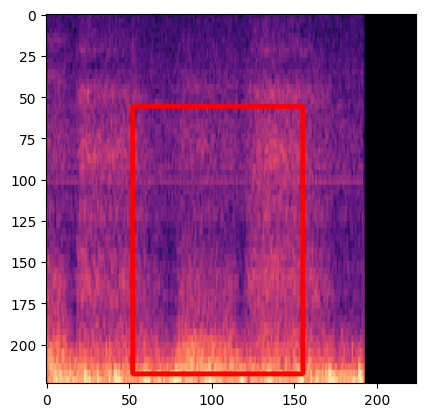

In [6]:
sample = cv2.imread('/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/png_file/163_8b3_Ar_mc_AKGC417L_2.png')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
point = box.iloc[0]
pt1 = (int(point['X_min']), int(point['Y_max']))
pt2 = (int(point['X_max']), int(point['Y_min']))
cv2.rectangle(sample, pt1, pt2, color=(255,0,0), thickness=2)
plt.imshow(sample)
plt.show()

In [7]:
dir_train = "/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset_ver2/train/images"
bbox_train = "/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/train.csv"
dir_val = "/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset_ver2/val/images"
bbox_val = "/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/val.csv"

In [8]:
box_train = pd.read_csv('/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/train.csv')
box_val = pd.read_csv('/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/val.csv')

In [9]:
class Dataset(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = df["Image_Name"].unique() # all image filenames
        self.df = df
        self.image_dir = image_dir # dir to image files
        self.transforms = transforms

        # 클래스 레이블 매핑
        self.class_mapping = {"normal": 1, "wheezes": 2, "crckles": 3}

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        records = self.df[self.df["Image_Name"] == image_id]
        image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
        heights, widths = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = torch.tensor(image)
        image = image.permute(2,0,1)
        
        boxes = records[["X_min", "Y_min", "X_max", "Y_max"]].values

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        masks = []
        for idx, box in enumerate(boxes):
            mask = np.zeros([int(heights), int(widths)], np.uint8)
            masks.append(cv2.rectangle(mask, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 1, -1))

        masks = torch.tensor(masks, dtype=torch.uint8)

        # 클래스 레이블을 숫자로 매핑
        labels = torch.tensor([self.class_mapping[label] for label in records["Label"]], dtype=torch.int64)
    
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["labels"] = labels
        target['masks'] = masks
        target["image_id"] = torch.tensor([idx])
        target["area"] = area

        if self.transforms:
            sample = {"image": image, "boxes": target["boxes"], "labels": labels}
            sample = self.transforms(**sample)
            image = sample["image"]
            target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["boxes"])))).permute(1, 0)

        return image, target

    def __len__(self):
        return self.image_ids.shape[0]


In [10]:
box.iloc[10]

Image_Name    145_3b4_Pl_mc_AKGC417L_1.png
Label                               normal
X_min                                    0
Y_min                                   56
X_max                                   43
Y_max                                  218
Name: 10, dtype: object

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_ds = Dataset(box_train, dir_train)
val_ds = Dataset(box_val, dir_val)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=3, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True, num_workers=3, collate_fn=collate_fn)

In [12]:
tmp_train = Dataset(box_train, dir_train)
tmp_val = Dataset(box_val, dir_val)

In [13]:
for i, (images, targets) in enumerate(train_dl):
    # print(i, (images, targets))
    print('images: ', type(images), len(images))
    print('targets: ',type(targets), len(targets))
    print(len(targets))
    
    break

images:  <class 'tuple'> 16
targets:  <class 'tuple'> 16
16


In [14]:
for i, (images, targets) in enumerate(val_dl):
    # print(i, (images, targets))
    print('images: ', type(images), len(images))
    print('targets: ',type(targets), len(targets))
    print(len(targets))
    
    break

images:  <class 'tuple'> 16
targets:  <class 'tuple'> 16
16


In [15]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [16]:
# class 1 + background 1 = 2
num_classes = 3

model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [18]:
model.train()

# 손실(loss) 기록을 위한 리스트 초기화
total_losses = []
regression_losses = []
classifier_losses = []
val_losses = []

val_loss_epoch = 0.0

num_epochs = 3

for epoch in range(num_epochs):
    total_loss_epoch = 0.0
    regression_loss_epoch = 0.0
    classifier_loss_epoch = 0.0
    val_loss_epoch = 0.0

    #모델을 훈련 모드로 설정
    model.train()
    
    for i, (images, targets) in enumerate(train_dl):
        optimizer.zero_grad()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        
        # 에포크별 손실(loss) 값 계산
        total_loss_epoch += losses.item()
        regression_loss_epoch += loss_dict["loss_box_reg"].item()
        classifier_loss_epoch += loss_dict["loss_classifier"].item()

        losses.backward()
        optimizer.step()

        if (i+1) % 40 == 0:
            print(f'Epoch {epoch+1} - Total: {losses:.4f}, Regression: {loss_dict["loss_box_reg"]:.4f}, Classifier: {loss_dict["loss_classifier"]:.4f}')
    
    # 검증 데이터셋에 대한 손실 계산
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in enumerate(val_dl):
            images_val = list(image.to(device) for image in images)
            targets_val = [{k: v.to(device) for k, v in t.items()} for t in targets]
            print(targets_val)
    
            # 모델에 이미지 전달하여 예측
            loss_dict_val = model(images_val, targets_val)
    
            # 손실 값을 딕셔너리로 변환하여 계산
            if isinstance(loss_dict, list):  # 만약 loss_dict가 리스트인 경우
                val_loss = sum(loss for loss in loss_dict_val)  # 리스트의 요소들의 손실을 합산
            else:
                val_loss = sum(loss_dict_val.values())  # 딕셔너리의 값들의 손실을 합산



            val_loss_epoch += val_loss.item() #검증 데이터셋 손실 누적



    # 에포크별 평균 손실(loss) 값 기록
    total_losses.append(total_loss_epoch / len(train_dl))
    regression_losses.append(regression_loss_epoch / len(train_dl))
    classifier_losses.append(classifier_loss_epoch / len(train_dl))
    val_losses.append(val_loss_epoch / len(val_dl))

    scheduler.step()

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), total_losses, label='Train Total Loss')
plt.plot(range(1, num_epochs + 1), regression_losses, label='Train Regression Loss')
plt.plot(range(1, num_epochs + 1), classifier_losses, label='Train Classifier Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
threshold = 0.8

In [ ]:
images = cv2.imread("//home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_224/png_files/101_1b1_Al_sc_Meditron_0.png", cv2.IMREAD_COLOR)
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images /= 255.0
sample = images
images = torch.tensor(images)
images = images.permute(2,0,1)
images = torch.unsqueeze(images, 0)
images = images.to(device)
model.eval()
cpu_device = torch.device("gpu")

preds = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in preds]
mask = outputs[0]['scores'] > threshold
boxes = outputs[0]["boxes"][mask].detach().numpy().astype(np.int32)

In [ ]:
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
plt.imshow(sample)
plt.show()